# Incheon_2015 Network and Analysis of Sturctural Change

## UNIST School of Natural Science

### Mathematical Science Major

### 20121229 JunPyo Park

About Folium?

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5ac9878e1e1550dea50a1f5b/adbdfd2fff8aa3075bfa1bbb72335221/image.png"></img>

Github Link : https://github.com/python-visualization/folium

## Codes

In [1]:
import os
import folium
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Read processed Data for whole Incheon

In [2]:
nodes = pd.read_csv('incheon_nodes_150105.csv')
links = pd.read_csv('incheon_links_150105.csv')

In [3]:
nodes = nodes[['Id','NODE_NAME','STNL_REG','latitude','longitude']]
incheon_id = dict()
for i in nodes['Id'] :
    incheon_id[i] = 0
len(nodes)

2200

Table for STNL_REG code

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5ac9b243203ce41785b600e0/96a8303881a66ac11ea45124b0635d92/image.png"></img>

In whole Incheon case, STNL_REG == 161~170

In [4]:
links = links[['Source','Target']]
links.head()

Source      Target
0  1610003100  1680004000
1  1610003100  1610003000
2  1680003800  1610003100
3  1610000800  1610000700
4  1610008600  1630014900

We shoud remove the links which is not connected in Incheon_nodes

In [5]:
source_in = links['Source'].apply(lambda x : x in incheon_id) # check Sources are in incheon_id
target_in = links['Target'].apply(lambda x : x in incheon_id) # check Targets are in incheon_id
# source_in and target_in are boolean type pandas.Series which contains True or False

In [6]:
incheon_links = links[source_in & target_in] # contain if both target and source are contained in incheon_id
incheon_links.head()

Source      Target
0  1610003100  1680004000
1  1610003100  1610003000
2  1680003800  1610003100
3  1610000800  1610000700
4  1610008600  1630014900

By checking the length, we can find that links are reduced from 6464 to 6421

In [7]:
print(len(links))
print(len(incheon_links))

6464
6421


Calculating Degree of each incheon_nodes

In [8]:
for ix, row in incheon_links.iterrows():
    incheon_id[row['Source']] += 1
    incheon_id[row['Target']] += 1

In [9]:
# Positioning the Standard Point for out Folium Map
std_point = tuple(nodes.head(1)[['latitude','longitude']].iloc[0])
std_point

(37.53527874510225, 126.56003651115343)

#### Using Networkx

Construct the network and data table here. <br>
If we assume the Earth as a perfect sphere, we can calculate the length between two nodes by using following formula

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5ad6becddd7e2be0e8dbd88a/b83b4330a4e13fcfd5af94e8fbf954a5/image.png"></img>

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5ad6becddd7e2be0e8dbd88a/f096c344ea7edf005c3dbf681be5003e/image.png"></img>

In [10]:
G = nx.Graph()
# R is the Earth's radius
R = 6371e3

for idx,row in nodes.iterrows():
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in incheon_links.iterrows():
    ## Calculate the distance between Source and Target Nodes
    lon1 = float(nodes[nodes['Id'] == row['Source']]['longitude'] * np.pi/180)
    lat1 = float(nodes[nodes['Id'] == row['Source']]['latitude'] * np.pi/180)
    lon2 = float(nodes[nodes['Id'] == row['Target']]['longitude'] * np.pi/180)
    lat2 = float(nodes[nodes['Id'] == row['Target']]['latitude'] * np.pi/180)
    
    d_lat = lat2 - lat1
    d_lon = lon2 - lon1
    a = np.sin(d_lat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_lon/2) ** 2
    c = 2 * np.arctan2(a**0.5, (1-a) ** 0.5)
    d = R * c
    ## Link attribute, 'Source', 'Target' and weight = 'Length between them'
    G.add_edge(row['Source'],row['Target'],weight = d)

In [11]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2200
Number of edges: 3233
Average degree:   2.9391


#### Using Gephi

In [12]:
nx.write_gexf(G,'Incheon_2015.gexf')

## Gephi Result

### Graph Over View

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5ad394e5aded2485139e183c/77d81ebf997a213519cad0a94885fbd9/image.png"></img>

### Data Table(Link)

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5ad6becddd7e2be0e8dbd88a/6bab1901e67aa1b47eb0bbe0a6af35b0/image.png"></img>

We can find 'Weight' attribute here.

## Draw Node

In [13]:
map_osm = folium.Map(location=std_point, zoom_start=10)

for ix, row in nodes.iterrows():
    location = (row['latitude'], row['longitude'])
    folium.Circle(
        location=location,
        radius=incheon_id[row['Id']] * 15,
        color='white',
        weight=1,
        fill_opacity=0.6,
        opacity=1,
        fill_color='red',
        fill=True,  # gets overridden by fill_color
        # popup=str(row['Id'])
    ).add_to(map_osm)
    # folium.Marker(location, popup=row['NODE_NAME']).add_to(map_osm)
# it takes some time.....
map_osm

## Draw Links

In [14]:
kw = {'opacity': 0.5, 'weight': 2}
for ix, row in incheon_links.iterrows():
    start = tuple(nodes[nodes['Id']==row['Source']][['latitude','longitude']].iloc[0])
    end = tuple(nodes[nodes['Id']==row['Target']][['latitude','longitude']].iloc[0])
    folium.PolyLine(
        locations=[start, end],
        color='blue',
        line_cap='round',
        **kw,
    ).add_to(map_osm)
# it takes some time.....
map_osm

## Analyze the change of structural property of the city

### 1. Visual Analysis

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5ac9b7dd71aece79325a5e04/831fc158378c363e704e41a907599ebe/image.png"></img>

<center>
Figure. 1. Change of structural property of the Incheon. <br>
Left : 2018.02.05,     Right : 2015.01.05
</center>

On the top left rectangle, Bridge which connects Samseon-myeon(삼산면) and Nega-myeon(내가면) was built. 
- Bridge name is '석모대교' which was opend since 2017.06.28
- Related Article Link : http://www.yonhapnews.co.kr/bulletin/2017/07/07/0200000000AKR20170707135700065.HTML

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5acb4adfefd12e4a702f2fb2/99d8bdf27ac8fe50814bb0a1eb5f5e70/image.png"></img>

<center>
Figure. 1.1. Article about '석모대교', which was opened sice 2017-06-28
</center>

At the east side of Incheon Internation Airport(Yeongjong district) there many roads are constructed.
- This is because of the IFEZ(Incheon Free Economic Zone) project.
- IFEZ Project Documentation : https://goo.gl/3DdBJ4
- Below figure shows the change of structural property of the Yeongjong district.
- Left : 2018, Right : 2015

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5acb73d98b96c3a12c16ebd9/5543ffbd0bffff90df3955a599078620/image.png"></img>

<center>
Figure. 1.2. Change of structural property of Yeongjong district. <br>
Left : 2018.02.05,     Right : 2015.01.05
</center>

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5acb53c546bb9e19191b3ae2/b978a6b84eaad7ad6ae52ffafd947303/image.png"></img>

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5acb73d98b96c3a12c16ebd9/57ae97cb069c7aa25fd3b9ad675a20d8/image.png"></img>

<center>
Figure. 1.3. Yeongjong Area Develpment Outline and Action Plan
</center>

Songdo International City(송도신도시) was also affected by this project.
- Below figure shows the change of structural property of the Songdo International City. 

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5ac9ff1b13ec2463052691df/8dd8bc3b05aea6f9d05c8f5b5cc268f3/image.png"></img>

<center>
Figure. 1.4. Change of structural property of Songdo International City. <br>
Left : 2018.02.05,     Right : 2015.01.05
</center>

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5acb73d98b96c3a12c16ebd9/fb4ab18b4cf6628a616d42b06281dea6/image.png"></img>

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5acb73d98b96c3a12c16ebd9/a91d6252af598ee99e9afb30fa798cbf/image.png"></img>

<center>
Figure. 1.5. Songdo International City Develpment Outline and Action Plan
</center>

### 3-2. Mathematical Analysis

#### Result Summary

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5ad7045f9faca28f3223121c/b9e139fe8db5e9384303ae69b00db575/image.png"></img>

#### Adjacency Matrix

In [102]:
# get adjacency matrix
A = nx.to_numpy_matrix(G, dtype=np.bool)# adjacency matrix, ignoring weight

In [103]:
A

matrix([[False,  True, False, ..., False, False, False],
        [ True, False,  True, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False,  True, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ..., False, False, False]])

In [104]:
A.shape

(2200, 2200)

#### Number of Length r cycle

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5ad7045f9faca28f3223121c/7b338d9d6b0c06bac396e0d43c0c33ae/image.png"></img>

In [79]:
ind = []
for i in range(10):
    ind.append('Length ' + str(i+1))
cycle = pd.Series(index = ind)
for i in range(10):
    cycle.iloc[i] = np.trace(np.linalg.matrix_power(A,i+1))
cycle

Length 1        0.0
Length 2     2198.0
Length 3      465.0
Length 4     2198.0
Length 5     1379.0
Length 6     2198.0
Length 7     1849.0
Length 8     2198.0
Length 9     2038.0
Length 10    2198.0
dtype: float64

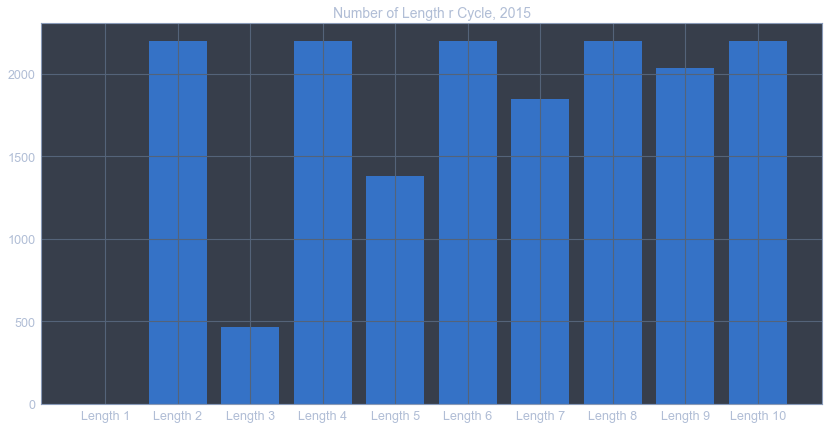

In [105]:
plt.figure(1, figsize=(14, 7))# control figure size
plt.bar(cycle.index, cycle)
plt.title('Number of Length r Cycle, 2015', fontsize=14);
# plt.show()

#### Diameter of Graph

#### Component : Block Matrix Form

In [100]:
nx.number_connected_components(G)

6

2015 : 6 components -> 2018 : 4 components <br>
There are two components reduction. <br>
One reduction is obviously due to the constuction of '석모대교'

### Further Study

#### Flow Analysis (Graph Laplacian)

Diffusion Equation

    - 도로별 교통량(통행량) 데이터 받아서 링크에 Attribute 추가
    - Directed Network

#### Bottleneck Analysis

#### Business Location Analysis

#### Finding Best Path

- Shortest Length
- Shortest Time